In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as matimg
import tensorflow as tf
from tensorflow import keras
from skimage import transform
import os
import imageio
import PIL

C:\Users\hashi\AppData\Local\Temp\ipykernel_28128\507206123.py:20: FutureWarning: `multichannel` is a deprecated argument name for `rescale`. It will be removed in version 1.0. Please use `channel_axis` instead.
  img = transform.rescale(img, scale, multichannel=True)


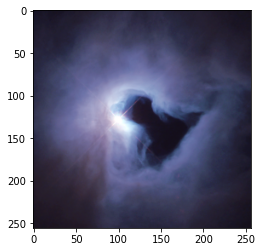

dimensions:
row: 256px col: 256px


In [2]:
# util functions for reading .tif/.png imgs

# takes a path for a .png format img and returns it as a np.ndarray
def read_img(path: str):
    try:
        img = plt.imread(path)
        return img
        
    except FileNotFoundError:
        print(f'unable to read path: {path} from the current directory')
        raise FileNotFoundError

# crop/resize .png format img to n x n x 3 img 
# default n = 256 so imgs are reformated to row: 256 col: 256 channels: 3 
def resize_img(img: np.ndarray, n: int=256):
    try:
        row, col, ch = img.shape

        scale = max(n / row, n / col)
        img = transform.rescale(img, scale, multichannel=True)
        return img[:n, :n, :]

    except:
        return f'unable to resize {*img.shape,} to 256, 256, 3'


# void function to graph a .png img to a matplotlib plot
def display_img(img: np.ndarray):
    plt.imshow(img)
    plt.show()

    row, col, ch = img.shape
    print(f'dimensions:\nrow: {row}px col: {col}px')

# example for reading and resizing a .png image from hubble_imgs and graphing it
img = read_img(r'./hubble_imgs_fixed/opo0010a.png')
img = resize_img(img)
display_img(img)


In [3]:
# UNPROCESSED DATA FROM KAGGLE: https://www.kaggle.com/datasets/redwankarimsony/top-100-hubble-telescope-images?resource=download
# had to delete some of the larger imgs from the dataset

# process training data from m,n,3 .tif imgs to 256,256,3 png imgs 
# commented out because i alr processed the data and deleted ./hubble_imgs 
# .tif img directory because it was taking up 4gbs of space
# for path in os.listdir(r'./hubble_imgs'):
#     read, write = os.path.join('hubble_imgs', path), os.path.join('hubble_imgs_fixed', path[:-4] + '.png')

#     img = resize_img(read_img(read))
#     matimg.imsave(write, img)

In [4]:
# reformating data into a csv *not really ideal the csv is very large so not really useable
# function which returns the csv header
def csv_header():
    repr = ''

    for row in range(256):
        for col in range(256):
            for channel in ('r', 'g', 'b', 'a'):
                repr += f'{row}x{col}{channel},'

    return repr[:-1]



# read data from directory *dirname into a formated processed csv
def imgs_to_csv(dirname: str, dest: str='hubble_data.csv'):
    try:
        # append each flattened img in hubble_img_fixed to hubble_imgs.csv file 
        with open(dest, 'ab') as csvstream:
            for img in os.listdir(dirname):
                img = read_img(os.path.join(dirname, img))
                # each channel *rgb has px values ranging from 0 to 1 as a floating pt num i.e x.xxxxxx
                np.savetxt(csvstream, img.reshape(1,262144), fmt='%1.6f', delimiter=',') 

    
    except FileNotFoundError:
        print(f'unable to find directory: {dirname}')

# imgs_to_csv('./hubble_imgs_fixed')
# img_df = pd.DataFrame(read_img('./hubble_imgs_fixed/opo0010a.png')[:, :, 0])
# print(img_df)
# print(csv_header())

In [5]:
# reads training/sample data to a ndarray and sets hyperparameters 
BUFFER_SIZE = 99
BATCH_SIZE = 11

dirname = './hubble_imgs_fixed/'
imgs = []

for basename in os.listdir('./hubble_imgs_fixed'):
    cur = plt.imread(f'{dirname}{basename}', format='png')
    imgs.append(cur)

TRAIN = np.array(imgs)
np.random.shuffle(TRAIN)
print(TRAIN.shape)

(96, 256, 256, 4)


In [9]:
# discriminator/classifier function for the gan
# downsamples and maxpools 256, 256, 4 tensors representing rgba imgs to a probability between 0 and 1 that the img is real
def make_discriminator(img_dim=(256, 256, 4), num_filters=64, num_layers=8):
    model = keras.Sequential()

    # input/img layer 256, 256, 4 tensor with values in range [0, 1]
    model.add(keras.layers.Input(shape=img_dim))

    # hidden convolutional layers downscale tensor/img to range [0, 1]
    for _ in range(num_layers):
        model.add(keras.layers.Conv2D(num_filters, kernel_size=8, strides=2, padding='same'))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.LeakyReLU(alpha=0.3))

    # output layer probability in range [0, 1] that img is real or fake
    model.add(keras.layers.GlobalAveragePooling2D())
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    return model


batch, row, col, channels: (1, 256, 256, 4)
min: -0.00043247549911029637
max: 0.0004734189424198121
untrained decision: [[0.5000002]]


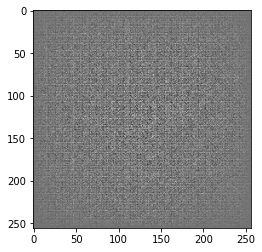

In [11]:
# generator function for the gan
# upsamples a normally distributed 100, 1 tensor to 256, 256, 4 tensors representing rgba img
def make_generator(latent_dim=(1, 100), num_filters=64, num_layers=7):
    model = keras.Sequential()

    # input/latent layer 100, 1 tensor with values normally distributed in the range [0, 1]
    latent_row, latent_col = latent_dim
    model.add(keras.layers.Dense(latent_col, input_dim=latent_col))
    model.add(keras.layers.LeakyReLU(alpha=0.3))
    model.add(keras.layers.Reshape((1, 1, latent_col)))

    # num_layers hidden convolutional layers to upsample image to 256, 256, 4 rgba img
    for _ in range(num_layers):
        model.add(keras.layers.Conv2DTranspose(num_filters, kernel_size=4, strides=2, padding='same'))
        model.add(keras.layers.LeakyReLU(alpha=0.3))
        num_filters *= 2

    # output layer
    model.add(keras.layers.Conv2DTranspose(4, kernel_size=4, strides=2, padding='same', activation='tanh'))

    return model



generator = make_generator()
disc = make_discriminator()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
print(f'batch, row, col, channels: {*generated_image.shape,}')
print(f'min: {np.min(generated_image)}\nmax: {np.max(generated_image)}')
print(f'untrained decision: {disc(generated_image)}')
plt.imshow(generated_image[0, :, :, 0], cmap='gray')





In [10]:
# function to make the dcgan
# default to using a generator which takes a normally distributed 1, 100 tensor and creates rgba imgs of dim 1, 256, 256, 4
# default to using a discriminator which takes a rgba img of dim 1, 256, 256, 4 and returns a probability in the range [0, 1]

def make_dcgan(dev=False):

    # compile discriminator
    discriminator = make_discriminator()
    discriminator.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0002), metrics=['mae'])

    # make generator
    generator = make_generator()

    # compile dcgan
    gan = keras.Sequential()
    gan.add(generator)
    gan.add(discriminator)
    discriminator.trainable = False 
    gan.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0002), metrics=['mae'])

    # return metrics if in dev mode
    if dev: 
        generator.summary()
        discriminator.summary()
        gan.summary()
        
    return generator, discriminator, gan
  
hubble_generator, hubble_discriminator, hubble_dcgan = make_dcgan(dev=True)


c:\Users\hashi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 100)               10100     
                                                                 
 leaky_re_lu_32 (LeakyReLU)  (None, 100)               0         
                                                                 
 reshape_2 (Reshape)         (None, 1, 1, 100)         0         
                                                                 
 conv2d_transpose_16 (Conv2D  (None, 2, 2, 64)         102464    
 Transpose)                                                      
                                                                 
 leaky_re_lu_33 (LeakyReLU)  (None, 2, 2, 64)          0         
                                                                 
 conv2d_transpose_17 (Conv2D  (None, 4, 4, 128)        131200    
 Transpose)                                           

In [ ]:
# train and 
DIS_UPDATES = 1
GEN_UPDATES = 1
